# SET

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [192]:
def carregar_arquivo_excel(caminho, sheet_name=0, skiprows=None):
    return pd.read_excel(caminho, sheet_name=sheet_name, skiprows=skiprows)

caminhos = {
'caminho_pccc_20_25' : r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\PCCC_20_25.XLSX",
'caminho_pccc_15_19':  r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\PCCC_15_19.XLSX",
'caminho_pccc_09_14' : r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\PCCC_09_14.XLSX",
'caminho_pccc_06_08' : r"C:\Users\fsp_adolpho.salvador\Desktop\Konica Minolta\Desktop Cloud - Documentos\Desktop\PCCC_06_08.XLSX",
}





In [193]:
def limpar_colunas(df, colunas_para_remover, nova_index=None, renomear_colunas=None):
    df = df.drop(columns=colunas_para_remover, errors='ignore')
    df = df.dropna()
    if renomear_colunas:
        df = df.rename(columns=renomear_colunas)
    if nova_index:
        df = df.set_index(nova_index)
    return df

In [ ]:
def preparar_dados_lstm(serie, n_steps):
    """
        Transforma uma série temporal em um conjunto de dados supervisionado para treino de LSTM,
    usando o padrão de janela deslizante (sliding window).

    Parâmetros:
    
    serie : array-like de shape (n_amostras,) ou (n_amostras, 1)
        Série temporal (normalizada) em que cada elemento é uma observação sequencial.
    n_steps : int
        Número de passos de tempo que formam cada janela de entrada.

    Retorna:
    
    X : np.ndarray de shape (n_amostras - n_steps, n_steps)
        Matrizes de entrada para o LSTM, onde cada linha corresponde a uma janela de tamanho n_steps.
    y : np.ndarray de shape (n_amostras - n_steps,)
        Vetor de saída contendo o valor imediatamente seguinte a cada janela de entrada.
    """
    X, y = [], []
    for i in range(n_steps, len(serie)):
        X.append(serie[i - n_steps:i])
        y.append(serie[i])
    return np.array(X), np.array(y)


In [ ]:
def prever_demanda_meses(df, n_meses=12):
    """
    Treina um modelo de rede neural LSTM sobre o histórico geral de consumo mensal
    e gera previsões para os próximos meses.

    Descrição:
    - O DataFrame é agrupado por mês de lançamento, somando as quantidades movimentadas.
    - A série temporal é normalizada entre 0 e 1 usando MinMaxScaler.
    - Utiliza-se uma janela de 192 meses como entrada para o modelo (n_steps=192).
    - Um modelo LSTM é treinado para aprender o padrão do consumo mensal.
    - Após o treinamento, são geradas previsões para os próximos 'n_meses' meses.
    - As previsões são revertidas à escala original e plotadas junto ao histórico recente.

    Parâmetros:
    - df (DataFrame): Dados de entrada contendo pelo menos as colunas:
        - 'Data de lançamento' (datas dos registros)
        - 'Qtd.  UM registro' (quantidade movimentada)
    - n_meses (int, opcional): Número de meses futuros que deseja prever. Padrão é 12.

    Retorno:
    - DataFrame com as colunas:
        - 'Mês Previsto': Período previsto no formato 'YYYY-MM'
        - 'Qtd Prevista': Quantidade estimada para o respectivo mês

    Observações:
    - A função exibe um gráfico com o histórico recente (a partir de 2023) e as previsões para facilitar a análise visual.
    - É recomendado que o DataFrame de entrada contenha pelo menos 200 meses de histórico para garantir treinamento adequado.
    """


    df = df.rename(columns=lambda x: x.strip())
    df = df.rename(columns={'Qtd.  UM registro': 'Qtd'})

    serie_mensal = df.groupby('Data de lançamento')['Qtd'].sum().sort_index()

    scaler = MinMaxScaler()
    serie_normalizada = scaler.fit_transform(serie_mensal.values.reshape(-1, 1))

    n_steps = 192
    X, y = preparar_dados_lstm(serie_normalizada, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=400, verbose=0)

    previsoes = []
    ultimos_passos = serie_normalizada[-n_steps:]

    for _ in range(n_meses):
        entrada = ultimos_passos.reshape((1, n_steps, 1))
        pred = model.predict(entrada, verbose=0)
        previsoes.append(pred[0][0])
        ultimos_passos = np.append(ultimos_passos[1:], pred, axis=0)

    previsoes_reais = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1)).flatten()

    ultimo_mes = pd.to_datetime(serie_mensal.index[-1] + "-01")
    proximos_meses = pd.date_range(start=ultimo_mes + pd.offsets.MonthBegin(), periods=n_meses, freq='MS').strftime('%Y-%m')

    tabela_previsoes = pd.DataFrame({
        'Mês Previsto': proximos_meses,
        'Qtd Prevista': previsoes_reais
    })

    serie_plot = pd.concat([serie_mensal[serie_mensal.index >= '2023-01'], 
                            pd.Series(previsoes_reais, index=proximos_meses)])
    serie_plot = serie_plot[serie_plot.index >= '2024-01']

    plt.figure(figsize=(10, 5))
    plt.plot(serie_plot.index, serie_plot.values, marker='o', linestyle='-')
    plt.title(f'Previsão de Demanda para 2024')
    plt.xlabel('Mês')
    plt.ylabel('Quantidade')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return tabela_previsoes


In [ ]:


def prever_demanda_lstm_por_material_az(df, materiais_az, n_steps=12, n_meses_prever=6, n_epochs=300):
    """
Treina e gera previsões de demanda usando um modelo LSTM separado para cada material listado.

Descrição:
- Para cada material informado, a função constrói uma série temporal mensal a partir do histórico de vendas/consumo.
- Em seguida, prepara os dados em formato supervisionado (usando janelas de n_steps meses anteriores para prever o mês seguinte).
- Treina um modelo de rede neural LSTM individualmente para cada material, utilizando apenas seus próprios dados históricos.
- Após o treinamento, gera previsões para os próximos meses e plota um gráfico com:
  - Linha histórica (consumo real)
  - Linha prevista (projeção da IA)

Parâmetros:
- df (DataFrame): DataFrame contendo os dados históricos, obrigatoriamente com as colunas:
    - 'Material': código ou nome do material.
    - 'Data de lançamento': data do registro de movimentação (estoque/consumo).
    - 'Qtd. UM registro': quantidade movimentada nesse lançamento.
- materiais_az (list ou array): Lista de materiais que serão previstos individualmente (ex: ['A33K133', 'PAPEL COUCHE']).
- n_steps (int, opcional): Número de meses consecutivos usados como janela de entrada para a rede LSTM (padrão = 12).
- n_meses_prever (int, opcional): Quantidade de meses futuros a serem previstos após o fim da série histórica (padrão = 6).
- n_epochs (int, opcional): Número de épocas de treinamento do modelo LSTM para cada material (padrão = 300).

Notas:
- Materiais com histórico insuficiente (menos de `n_steps + 1` meses) serão automaticamente ignorados.
- A normalização dos dados é feita internamente usando MinMaxScaler para otimizar o desempenho do LSTM.
- Cada material é tratado de forma independente, com um modelo próprio e previsões específicas.
    """

    # Garantir formato de data e criar coluna AnoMes
    df = df.copy()
    df['Data de lançamento'] = pd.to_datetime(df['Data de lançamento'])
    df['AnoMes'] = df['Data de lançamento'].dt.to_period('M')

    def preparar_dados_lstm(serie, n_steps):
        X, y = [], []
        for i in range(n_steps, len(serie)):
            X.append(serie[i - n_steps:i])
            y.append(serie[i])
        return np.array(X), np.array(y)

    for mat in materiais_az:
        dados_mat = df[df['Material'] == mat]
        serie_mensal = dados_mat.groupby('AnoMes')['Qtd.  UM registro'].sum().sort_index()

        if len(serie_mensal) < n_steps + 1:
            print(f"Pulando {mat} - poucos dados ({len(serie_mensal)} meses)")
            continue

        scaler = MinMaxScaler()
        serie_normalizada = scaler.fit_transform(serie_mensal.values.reshape(-1, 1))

        X, y = preparar_dados_lstm(serie_normalizada, n_steps)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=n_epochs, verbose=0)

        previsoes = []
        entrada = serie_normalizada[-n_steps:]

        for _ in range(n_meses_prever):
            entrada_reshaped = entrada.reshape((1, n_steps, 1))
            pred = model.predict(entrada_reshaped, verbose=0)[0][0]
            previsoes.append(pred)
            entrada = np.append(entrada[1:], [[pred]], axis=0)

        previsoes_reais = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1)).flatten()

        plt.figure(figsize=(10, 4))
        plt.plot(serie_mensal.index.astype(str), serie_mensal.values, label='Histórico')
        proximos_meses = pd.date_range(start=serie_mensal.index[-1].to_timestamp() + pd.offsets.MonthBegin(),
                                       periods=n_meses_prever, freq='MS').strftime('%Y-%m')
        plt.plot(proximos_meses, previsoes_reais, label='Previsão', marker='o')
        plt.title(f'Previsão para {mat} (Classe AZ)')
        plt.xlabel('Mês')
        plt.ylabel('Quantidade')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()


In [197]:
def tratar_dados(df: pd.DataFrame) -> pd.DataFrame:
    df['Data de lançamento'] = pd.to_datetime(df['Data de lançamento'], errors='coerce')
    
    df['Data de lançamento'] = df['Data de lançamento'].dt.to_period('M').astype(str)

    df['Qtd.  UM registro'] = df['Qtd.  UM registro'] * -1

    return df


### Limpando

In [198]:
pccc_20_25 = carregar_arquivo_excel(caminhos['caminho_pccc_20_25'])
pccc_15_19 = carregar_arquivo_excel(caminhos['caminho_pccc_15_19'])
pccc_09_14 = carregar_arquivo_excel(caminhos['caminho_pccc_09_14'])
pccc_06_08 = carregar_arquivo_excel(caminhos['caminho_pccc_06_08'])

In [199]:
pccc_20_25.columns

Index(['Material', 'Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material',
       'Data de lançamento', 'Qtd.  UM registro', 'UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação'],
      dtype='object')

In [200]:
colunas_remover = ['Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material','UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação']



pccc_20_25 = limpar_colunas(pccc_20_25, colunas_remover, nova_index='Material')
pccc_15_19 = limpar_colunas(pccc_15_19, colunas_remover, nova_index='Material')
pccc_09_14 = limpar_colunas(pccc_09_14, colunas_remover, nova_index='Material')
pccc_06_08 = limpar_colunas(pccc_06_08, colunas_remover, nova_index='Material')




In [201]:
pccc_total = pd.concat([pccc_20_25, pccc_15_19, pccc_09_14, pccc_06_08], ignore_index=True)

In [202]:
pccc_total = tratar_dados(pccc_total)

In [203]:
pccc_total.columns

Index(['Data de lançamento', 'Qtd.  UM registro'], dtype='object')

In [204]:
pccc_ate_2023 = pccc_total[pccc_total['Data de lançamento'] < '2024-01']


In [205]:
pccc_total

,Data de lançamento,Qtd. UM registro
0,2025-04,1
1,2025-04,3
2,2025-04,1
3,2025-04,2
4,2025-04,1
...,...,...
605955,2006-01,1
605956,2006-01,1
605957,2006-01,1
605958,2006-01,1


In [206]:
pccc_ate_2023

,Data de lançamento,Qtd. UM registro
59341,2023-12,2
59342,2023-12,2
59343,2023-12,16
59344,2023-12,9
59345,2023-12,8
...,...,...
605955,2006-01,1
605956,2006-01,1
605957,2006-01,1
605958,2006-01,1


# consolidado

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


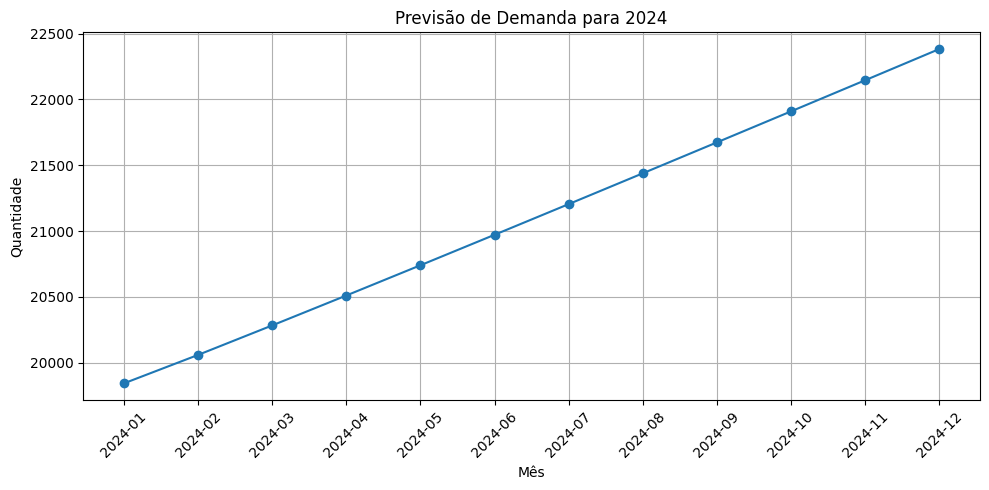

Mês Previsto  Qtd Prevista
     2024-01  19842.580078
     2024-02  20058.595703
     2024-03  20282.607422
     2024-04  20509.878906
     2024-05  20739.597656
     2024-06  20971.169922
     2024-07  21204.146484
     2024-08  21438.205078
     2024-09  21673.109375
     2024-10  21908.755859
     2024-11  22145.113281
     2024-12  22382.226562


In [207]:
tabela_2024 = prever_demanda_meses(pccc_ate_2023, n_meses=12)
print(tabela_2024.to_string(index=False))

In [208]:
pccc_total.columns = pccc_total.columns.str.strip()
pccc_total = pccc_total.rename(columns={'Qtd.  UM registro': 'Qtd'})

pccc_2024 = pccc_total[pccc_total['Data de lançamento'].str.startswith('2024')]

tabela_2024 = pccc_2024.groupby('Data de lançamento')['Qtd'].sum().reset_index()
tabela_2024.columns = ['Mês', 'Quantidade Total']

print("\n Valores já registrados em 2024 no pccc_total:\n")
print(tabela_2024.to_string(index=False))



 Valores já registrados em 2024 no pccc_total:

    Mês  Quantidade Total
2024-01             16951
2024-02             15910
2024-03             20799
2024-04             24695
2024-05             21079
2024-06             18761
2024-07             23163
2024-08             18830
2024-09             21348
2024-10             25105
2024-11             21031
2024-12             37398


### Comparação de tabelas

In [ ]:
previsao_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Prevista': [
        18919.91, 19154.69, 19202.46, 19250.48, 19288.11, 19320.03,
        19348.03, 19373.22, 19396.05, 19417.14, 19436.68, 19454.69
    ]
})

real_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Real': [
        16951, 15910, 20799, 24695, 21079, 18761,
        23163, 18830, 21348, 25105, 21031, 37398
    ]
})

comparacao = pd.merge(previsao_2024, real_2024, on='Mês')
comparacao['Erro Absoluto'] = abs(comparacao['Qtd Prevista'] - comparacao['Qtd Real'])
comparacao['Erro (%)'] = 100 * comparacao['Erro Absoluto'] / comparacao['Qtd Real']

mape = comparacao['Erro (%)'].mean()

print("\n Comparação entre Previsão e Real (2024)(n=12, epo =400):\n")
print(comparacao.to_string(index=False))
print(f"\n MAPE (Erro Percentual Médio): {mape:.2f}%")



 Comparação entre Previsão e Real (2024)(n=12, epo =400):

    Mês  Qtd Prevista  Qtd Real  Erro Absoluto  Erro (%)
2024-01      18919.91     16951        1968.91 11.615303
2024-02      19154.69     15910        3244.69 20.394029
2024-03      19202.46     20799        1596.54  7.676042
2024-04      19250.48     24695        5444.52 22.047054
2024-05      19288.11     21079        1790.89  8.496086
2024-06      19320.03     18761         559.03  2.979745
2024-07      19348.03     23163        3814.97 16.470103
2024-08      19373.22     18830         543.22  2.884865
2024-09      19396.05     21348        1951.95  9.143479
2024-10      19417.14     25105        5687.86 22.656284
2024-11      19436.68     21031        1594.32  7.580809
2024-12      19454.69     37398       17943.31 47.979330

 MAPE (Erro Percentual Médio): 14.99%


In [ ]:

# Previsões geradas
previsao_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Prevista': [
        18919.91, 19154.69, 19202.46, 19250.48, 19288.11, 19320.03,
        19348.03, 19373.22, 19396.05, 19417.14, 19436.68, 19454.69
    ]
})

# Valores reais extraídos do pccc_total
real_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Real': [
        16951, 15910, 20799, 24695, 21079, 18761,
        23163, 18830, 21348, 25105, 21031, 37398
    ]
})

comparacao = pd.merge(previsao_2024, real_2024, on='Mês')
comparacao['Erro Absoluto'] = abs(comparacao['Qtd Prevista'] - comparacao['Qtd Real'])
comparacao['Erro (%)'] = 100 * comparacao['Erro Absoluto'] / comparacao['Qtd Real']

mape = comparacao['Erro (%)'].mean()

# Mostrar
print("\n Comparação entre Previsão e Real (2024)  (n_steps = 72,epochs=400):\n")
print(comparacao.to_string(index=False))
print(f"\n MAPE (Erro Percentual Médio): {mape:.2f}%")


 Comparação entre Previsão e Real (2024)  (n_steps = 72,epochs=400):

    Mês  Qtd Prevista  Qtd Real  Erro Absoluto  Erro (%)
2024-01      18919.91     16951        1968.91 11.615303
2024-02      19154.69     15910        3244.69 20.394029
2024-03      19202.46     20799        1596.54  7.676042
2024-04      19250.48     24695        5444.52 22.047054
2024-05      19288.11     21079        1790.89  8.496086
2024-06      19320.03     18761         559.03  2.979745
2024-07      19348.03     23163        3814.97 16.470103
2024-08      19373.22     18830         543.22  2.884865
2024-09      19396.05     21348        1951.95  9.143479
2024-10      19417.14     25105        5687.86 22.656284
2024-11      19436.68     21031        1594.32  7.580809
2024-12      19454.69     37398       17943.31 47.979330

 MAPE (Erro Percentual Médio): 14.99%


In [211]:
previsao_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Prevista': [
        19973.26, 20298.67, 20643.86, 21008.06, 21390.83, 21792.33,
        22212.87, 22653.00, 23113.56, 23595.57, 24100.38, 24629.71
    ]
})

# Valores reais extraídos do pccc_total
real_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Real': [
        16951, 15910, 20799, 24695, 21079, 18761,
        23163, 18830, 21348, 25105, 21031, 37398
    ]
})

# Unir as tabelas
comparacao = pd.merge(previsao_2024, real_2024, on='Mês')
comparacao['Erro Absoluto'] = abs(comparacao['Qtd Prevista'] - comparacao['Qtd Real'])
comparacao['Erro (%)'] = 100 * comparacao['Erro Absoluto'] / comparacao['Qtd Real']

# Calcular MAPE
mape = comparacao['Erro (%)'].mean()

# Mostrar
print("\n Comparação entre Previsão e Real (2024)  (n_steps = 194,epochs=400):\n")
print(comparacao.to_string(index=False))
print(f"\n MAPE (Erro Percentual Médio): {mape:.2f}%")


 Comparação entre Previsão e Real (2024)  (n_steps = 194,epochs=400):

    Mês  Qtd Prevista  Qtd Real  Erro Absoluto  Erro (%)
2024-01      19973.26     16951        3022.26 17.829391
2024-02      20298.67     15910        4388.67 27.584349
2024-03      20643.86     20799         155.14  0.745901
2024-04      21008.06     24695        3686.94 14.929905
2024-05      21390.83     21079         311.83  1.479340
2024-06      21792.33     18761        3031.33 16.157614
2024-07      22212.87     23163         950.13  4.101930
2024-08      22653.00     18830        3823.00 20.302708
2024-09      23113.56     21348        1765.56  8.270377
2024-10      23595.57     25105        1509.43  6.012468
2024-11      24100.38     21031        3069.38 14.594551
2024-12      24629.71     37398       12768.29 34.141639

 MAPE (Erro Percentual Médio): 13.85%


# canal

In [212]:
pccc_20_25 = carregar_arquivo_excel(caminhos['caminho_pccc_20_25'])
pccc_15_19 = carregar_arquivo_excel(caminhos['caminho_pccc_15_19'])
pccc_09_14 = carregar_arquivo_excel(caminhos['caminho_pccc_09_14'])
pccc_06_08 = carregar_arquivo_excel(caminhos['caminho_pccc_06_08'])

In [213]:
pccc_total = pd.concat([pccc_20_25, pccc_15_19,pccc_09_14,pccc_06_08])

In [214]:
pccc_total.columns

Index(['Material', 'Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material',
       'Data de lançamento', 'Qtd.  UM registro', 'UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação'],
      dtype='object')

In [215]:
pccc_total['Canal'].unique()

array(['VENDA DIRETA', 'VENDA INDIRETA', 'USO E CONSUMO',
       'USO E CONSUMO MAO', nan, 'DESCREDENCIADA', 'MATRIZ'], dtype=object)

In [216]:
pccc_venda_indireta = pccc_total[pccc_total['Canal'].str.upper().str.strip() == 'VENDA INDIRETA']
pccc_venda_direta = pccc_total[pccc_total['Canal'].str.upper().str.strip() == 'VENDA DIRETA']


In [217]:
pccc_venda_indireta.columns

Index(['Material', 'Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material',
       'Data de lançamento', 'Qtd.  UM registro', 'UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação'],
      dtype='object')

In [218]:
colunas_remover = ['Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material','UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Classificação']

pccc_venda_indireta = limpar_colunas(pccc_venda_indireta, colunas_remover, nova_index='Material')
pccc_venda_direta = limpar_colunas(pccc_venda_direta, colunas_remover, nova_index='Material')

In [219]:
pccc_venda_indireta

,Data de lançamento,Qtd. UM registro,Canal
Material,,,
AAV70RD,2025-04-24,-4,VENDA INDIRETA
ACVH230,2025-04-24,-10,VENDA INDIRETA
ACVH330,2025-04-24,-10,VENDA INDIRETA
ACVH430,2025-04-24,-10,VENDA INDIRETA
A3VV130,2025-04-23,-15,VENDA INDIRETA
...,...,...,...
8937920,2006-01-04,-5,VENDA INDIRETA
8937921,2006-01-04,-4,VENDA INDIRETA
8937922,2006-01-04,-7,VENDA INDIRETA


In [220]:
pccc_venda_indireta = tratar_dados(pccc_venda_indireta)
pccc_venda_direta = tratar_dados(pccc_venda_direta)

## direta

In [221]:
df_lstm_direta = pccc_venda_direta.groupby(['Canal', 'Data de lançamento'])['Qtd.  UM registro'].sum().reset_index()


In [222]:
df_lstm_direta

,Canal,Data de lançamento,Qtd. UM registro
0,VENDA DIRETA,2006-01,297
1,VENDA DIRETA,2006-02,242
2,VENDA DIRETA,2006-03,250
3,VENDA DIRETA,2006-04,252
4,VENDA DIRETA,2006-05,248
...,...,...,...
216,VENDA DIRETA,2024-12,6875
217,VENDA DIRETA,2025-01,4559
218,VENDA DIRETA,2025-02,5701
219,VENDA DIRETA,2025-03,5568


In [223]:
df_lstm_direta = df_lstm_direta[df_lstm_direta['Data de lançamento'] <= '2023-12']
df_lstm_direta

,Canal,Data de lançamento,Qtd. UM registro
0,VENDA DIRETA,2006-01,297
1,VENDA DIRETA,2006-02,242
2,VENDA DIRETA,2006-03,250
3,VENDA DIRETA,2006-04,252
4,VENDA DIRETA,2006-05,248
...,...,...,...
200,VENDA DIRETA,2023-08,7054
201,VENDA DIRETA,2023-09,6582
202,VENDA DIRETA,2023-10,6891
203,VENDA DIRETA,2023-11,6860


c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


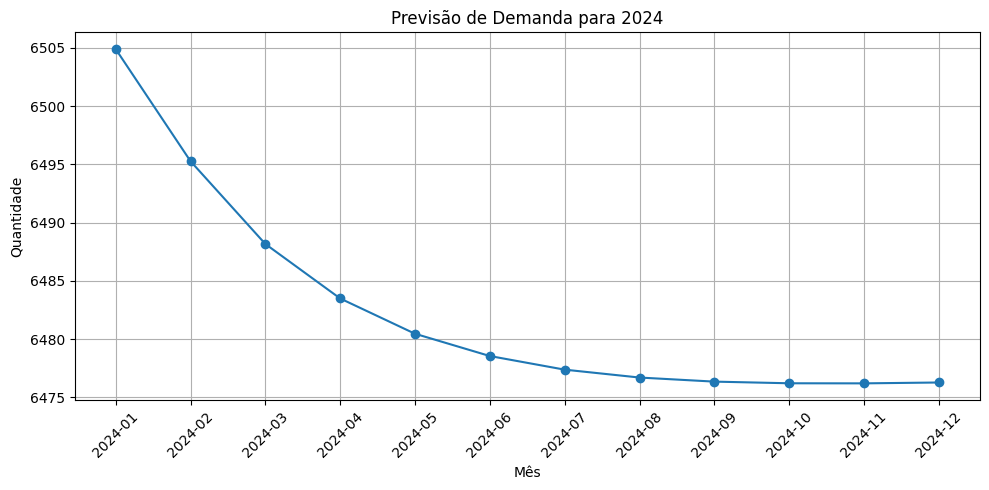

,Mês Previsto,Qtd Prevista
0,2024-01,6504.893066
1,2024-02,6495.267090
2,2024-03,6488.162598
3,2024-04,6483.485352
4,2024-05,6480.458008
5,2024-06,6478.545410
6,2024-07,6477.376465
7,2024-08,6476.700195
8,2024-09,6476.349121
9,2024-10,6476.207520


In [224]:
prever_demanda_meses(df_lstm_direta, n_meses=12)

In [225]:
pccc_venda_direta_2024 = pccc_venda_direta[pccc_venda_direta['Data de lançamento'].str.startswith('2024')]

In [226]:
tabela_venda_direta_2024 = (
    pccc_venda_direta_2024
    .groupby('Data de lançamento')['Qtd.  UM registro']
    .sum()
    .reset_index()
)

# Renomear colunas pra ficar bonitinho
tabela_venda_direta_2024.columns = ['Mês', 'Quantidade Total']


In [227]:
tabela_venda_direta_2024

,Mês,Quantidade Total
0,2024-01,5365
1,2024-02,5276
2,2024-03,7077
3,2024-04,7062
4,2024-05,5387
5,2024-06,5780
6,2024-07,6705
7,2024-08,7058
8,2024-09,6282
9,2024-10,6961


### Analisando resultados

In [228]:

real_venda_direta_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Real': [
        5365, 5276, 7077, 7062, 5387, 5780,
        6705, 7058, 6282, 6961, 6644, 6875
    ]
})

previsao_venda_direta_2024 = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Prevista': [
        6552.55, 6542.64, 6534.02, 6526.04, 6518.63, 6511.72,
        6505.28, 6499.25, 6493.62, 6488.34, 6483.39, 6478.75
    ]
})

comparacao = pd.merge(real_venda_direta_2024, previsao_venda_direta_2024, on='Mês')
comparacao['Erro Absoluto'] = abs(comparacao['Qtd Prevista'] - comparacao['Qtd Real'])
comparacao['Erro (%)'] = 100 * comparacao['Erro Absoluto'] / comparacao['Qtd Real']

mape = comparacao['Erro (%)'].mean()

print("\n Comparação VENDA DIRETA 2024:\n")
print(comparacao.to_string(index=False))
print(f"\n MAPE (Erro Percentual Médio): {mape:.2f}%")


 Comparação VENDA DIRETA 2024:

    Mês  Qtd Real  Qtd Prevista  Erro Absoluto  Erro (%)
2024-01      5365       6552.55        1187.55 22.135135
2024-02      5276       6542.64        1266.64 24.007582
2024-03      7077       6534.02         542.98  7.672460
2024-04      7062       6526.04         535.96  7.589351
2024-05      5387       6518.63        1131.63 21.006683
2024-06      5780       6511.72         731.72 12.659516
2024-07      6705       6505.28         199.72  2.978673
2024-08      7058       6499.25         558.75  7.916549
2024-09      6282       6493.62         211.62  3.368672
2024-10      6961       6488.34         472.66  6.790116
2024-11      6644       6483.39         160.61  2.417369
2024-12      6875       6478.75         396.25  5.763636

 MAPE (Erro Percentual Médio): 10.36%


## indireta

In [229]:
df_lstm_indireta = pccc_venda_indireta.groupby(['Canal', 'Data de lançamento'])['Qtd.  UM registro'].sum().reset_index()


In [230]:
df_lstm_indireta = df_lstm_indireta[df_lstm_indireta['Data de lançamento'] <= '2023-12']


In [231]:
df_lstm_indireta

,Canal,Data de lançamento,Qtd. UM registro
0,VENDA INDIRETA,2006-01,1209
1,VENDA INDIRETA,2006-02,1861
2,VENDA INDIRETA,2006-03,847
3,VENDA INDIRETA,2006-04,918
4,VENDA INDIRETA,2006-05,1777
...,...,...,...
200,VENDA INDIRETA,2023-08,11063
201,VENDA INDIRETA,2023-09,17163
202,VENDA INDIRETA,2023-10,11435
203,VENDA INDIRETA,2023-11,10923


c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


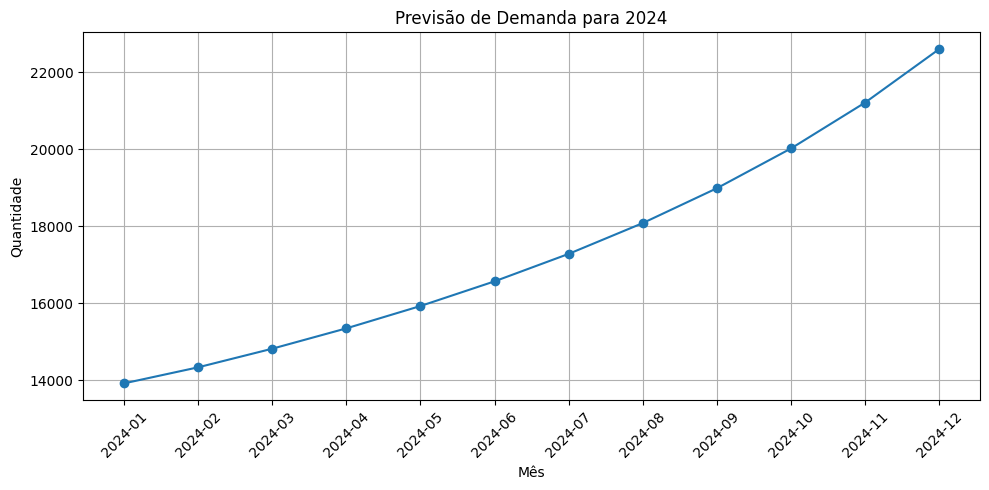

,Mês Previsto,Qtd Prevista
0,2024-01,13923.480469
1,2024-02,14340.400391
2,2024-03,14823.733398
3,2024-04,15352.396484
4,2024-05,15932.639648
5,2024-06,16573.707031
6,2024-07,17287.046875
7,2024-08,18087.093750
8,2024-09,18992.130859
9,2024-10,20025.357422


In [232]:
prever_demanda_meses(df_lstm_indireta, n_meses=12)

In [233]:
pccc_venda_indireta_2024 = pccc_venda_indireta[pccc_venda_indireta['Data de lançamento'].str.startswith('2024')]

tabela_venda_indireta_2024 = (
    pccc_venda_indireta_2024
    .groupby('Data de lançamento')['Qtd.  UM registro']
    .sum()
    .reset_index()
)

# Renomear colunas pra ficar bonitinho
tabela_venda_indireta_2024.columns = ['Mês', 'Quantidade Total']

In [234]:
tabela_venda_indireta_2024

,Mês,Quantidade Total
0,2024-01,11538
1,2024-02,10612
2,2024-03,13654
3,2024-04,15540
4,2024-05,15659
5,2024-06,12850
6,2024-07,16388
7,2024-08,11727
8,2024-09,15035
9,2024-10,18086


### Analisando resultados

In [235]:

real_2024_indireta = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Real': [
        11538, 10612, 13654, 15540, 15659, 12850,
        16388, 11727, 15035, 18086, 11602, 30453
    ]
})

previsto_2024_indireta = pd.DataFrame({
    'Mês': [
        '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06',
        '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12'
    ],
    'Qtd Prevista': [
        13020.82, 13276.03, 13542.58, 13823.19, 14119.71, 14434.00,
        14768.21, 15124.79, 15506.56, 15916.78, 16359.24, 16838.38
    ]
})

comparacao = pd.merge(real_2024_indireta, previsto_2024_indireta, on='Mês')
comparacao['Erro Absoluto'] = abs(comparacao['Qtd Real'] - comparacao['Qtd Prevista'])
comparacao['Erro (%)'] = 100 * comparacao['Erro Absoluto'] / comparacao['Qtd Real']

mape = comparacao['Erro (%)'].mean()

print("\n Comparação VENDA INDIRETA 2024:\n")
print(comparacao.to_string(index=False))
print(f"\n MAPE (Erro Percentual Médio): {mape:.2f}%")



 Comparação VENDA INDIRETA 2024:

    Mês  Qtd Real  Qtd Prevista  Erro Absoluto  Erro (%)
2024-01     11538      13020.82        1482.82 12.851621
2024-02     10612      13276.03        2664.03 25.103939
2024-03     13654      13542.58         111.42  0.816025
2024-04     15540      13823.19        1716.81 11.047683
2024-05     15659      14119.71        1539.29  9.830066
2024-06     12850      14434.00        1584.00 12.326848
2024-07     16388      14768.21        1619.79  9.884000
2024-08     11727      15124.79        3397.79 28.974077
2024-09     15035      15506.56         471.56  3.136415
2024-10     18086      15916.78        2169.22 11.993918
2024-11     11602      16359.24        4757.24 41.003620
2024-12     30453      16838.38       13614.62 44.706991

 MAPE (Erro Percentual Médio): 17.64%


# material

## abc/xyz 19 anos

In [236]:
pccc_20_25 = carregar_arquivo_excel(caminhos['caminho_pccc_20_25'])
pccc_15_19 = carregar_arquivo_excel(caminhos['caminho_pccc_15_19'])
pccc_09_14 = carregar_arquivo_excel(caminhos['caminho_pccc_09_14'])
pccc_06_08 = carregar_arquivo_excel(caminhos['caminho_pccc_06_08'])

In [237]:
pccc_total = pd.concat([pccc_20_25, pccc_15_19,pccc_09_14,pccc_06_08])

In [238]:
pccc_total

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-24,-1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-24,-3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-24,-1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-24,-2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-24,-1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24212,8937753,CE01,DEP2,601,NaN,49030039,4,2006-01-03,-1,UND,1810.0,NaN,SAMSUNG SDI BRASIL LTDA,VENDA DIRETA,VD_CLI_MAO
24213,1161029201,CE01,DEP2,601,NaN,49030064,2,2006-01-03,-1,UND,312.0,NaN,M. SANSEVERINO & CIA. LTDA,DESCREDENCIADA,VI_REVENDA
24214,4518802,CE01,DEP2,601,NaN,49030031,1,2006-01-02,-1,UND,105.0,NaN,ATS VIAGENS E TURISMO LTDA,VENDA DIRETA,VD_CLI_MAO
24215,4518802,CE01,DEP2,601,NaN,49030034,1,2006-01-02,-1,UND,1741.0,NaN,RIBEIRO E SOARES LTDA,VENDA DIRETA,VD_CLI_MAO


In [239]:
pccc_total = tratar_dados(pccc_total)

In [240]:
pccc_total

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24212,8937753,CE01,DEP2,601,NaN,49030039,4,2006-01,1,UND,1810.0,NaN,SAMSUNG SDI BRASIL LTDA,VENDA DIRETA,VD_CLI_MAO
24213,1161029201,CE01,DEP2,601,NaN,49030064,2,2006-01,1,UND,312.0,NaN,M. SANSEVERINO & CIA. LTDA,DESCREDENCIADA,VI_REVENDA
24214,4518802,CE01,DEP2,601,NaN,49030031,1,2006-01,1,UND,105.0,NaN,ATS VIAGENS E TURISMO LTDA,VENDA DIRETA,VD_CLI_MAO
24215,4518802,CE01,DEP2,601,NaN,49030034,1,2006-01,1,UND,1741.0,NaN,RIBEIRO E SOARES LTDA,VENDA DIRETA,VD_CLI_MAO


In [241]:
pccc_total.columns

Index(['Material', 'Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material',
       'Data de lançamento', 'Qtd.  UM registro', 'UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação'],
      dtype='object')

In [242]:
pccc_total['Data de lançamento'] = pd.to_datetime(pccc_total['Data de lançamento'])
pccc_total['AnoMes'] = pccc_total['Data de lançamento'].dt.to_period('M')

demanda_mensal = pccc_total.groupby(['Material', 'AnoMes'])['Qtd.  UM registro'].sum().unstack(fill_value=0)


In [243]:
total_por_material = demanda_mensal.sum(axis=1)
percentual = total_por_material / total_por_material.sum()

# Ordenar do maior pro menor
df_abc = percentual.sort_values(ascending=False).cumsum()

# Criar categoria ABC
def classificar_abc(x):
    if x <= 0.8:
        return 'A'
    elif x <= 0.95:
        return 'B'
    else:
        return 'C'

classe_abc = df_abc.apply(classificar_abc)


In [244]:
media = demanda_mensal.mean(axis=1)
desvio = demanda_mensal.std(axis=1)
cv = (desvio / media).fillna(0)

def classificar_xyz(x):
    if x <= 0.5:
        return 'X'
    elif x <= 1:
        return 'Y'
    else:
        return 'Z'

classe_xyz = cv.apply(classificar_xyz)


In [245]:
df_classificacao = pd.DataFrame({
    'Total Movimentado': total_por_material,
    'Classe ABC': classe_abc,
    'Coef. Variação': cv,
    'Classe XYZ': classe_xyz
})

df_classificacao['Classe ABC/XYZ'] = df_classificacao['Classe ABC'] + df_classificacao['Classe XYZ']


In [246]:
df_classificacao

,Total Movimentado,Classe ABC,Coef. Variação,Classe XYZ,Classe ABC/XYZ
Material,,,,,
020V,474,C,2.843253,Z,CZ
020W,887,C,2.761773,Z,CZ
020X,634,C,2.785393,Z,CZ
020Y,741,C,2.820423,Z,CZ
020Z,123,C,2.616506,Z,CZ
...,...,...,...,...,...
TN650BR,410,C,4.074631,Z,CZ
TN650S,1285,C,3.038191,Z,CZ
TN650SBR,362,C,4.903544,Z,CZ


In [247]:
pccc_total

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-01,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-01,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP,2025-04
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-01,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24212,8937753,CE01,DEP2,601,NaN,49030039,4,2006-01-01,1,UND,1810.0,NaN,SAMSUNG SDI BRASIL LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01
24213,1161029201,CE01,DEP2,601,NaN,49030064,2,2006-01-01,1,UND,312.0,NaN,M. SANSEVERINO & CIA. LTDA,DESCREDENCIADA,VI_REVENDA,2006-01
24214,4518802,CE01,DEP2,601,NaN,49030031,1,2006-01-01,1,UND,105.0,NaN,ATS VIAGENS E TURISMO LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01
24215,4518802,CE01,DEP2,601,NaN,49030034,1,2006-01-01,1,UND,1741.0,NaN,RIBEIRO E SOARES LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01


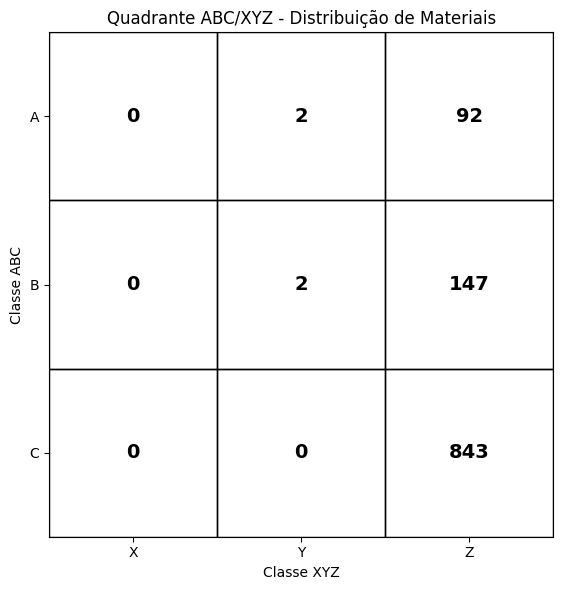

In [248]:
abc_labels = ['A', 'B', 'C']
xyz_labels = ['X', 'Y', 'Z']

tabela = pd.crosstab(df_classificacao['Classe ABC'], df_classificacao['Classe XYZ'])
tabela = tabela.reindex(index=abc_labels, columns=xyz_labels, fill_value=0)
data = tabela.values

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(abc_labels)):
    for j in range(len(xyz_labels)):
        valor = data[i, j]
        ax.text(j, i, str(valor), va='center', ha='center', fontsize=14, fontweight='bold', color='black')
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', lw=1))

ax.set_xticks(np.arange(len(xyz_labels)))
ax.set_xticklabels(xyz_labels)
ax.set_yticks(np.arange(len(abc_labels)))
ax.set_yticklabels(abc_labels)
ax.set_xlabel('Classe XYZ')
ax.set_ylabel('Classe ABC')
ax.set_title('Quadrante ABC/XYZ - Distribuição de Materiais')

ax.set_xlim(-0.5, len(xyz_labels) - 0.5)
ax.set_ylim(len(abc_labels) - 0.5, -0.5)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [249]:
pccc_az = df_classificacao[df_classificacao['Classe ABC/XYZ'] == 'AZ'].reset_index()
lista_materiais_az = pccc_az['Material'].unique().tolist()


In [250]:
lista_materiais_az

['02UJ',
 '02XJ',
 '4021029701',
 '4053401',
 '4053501',
 '4518602',
 '4519601',
 '8936488',
 '8937782',
 '8938505',
 '8938506',
 '8938507',
 '8938508',
 'A04P230',
 'A04P330',
 'A04P430',
 'A0D7135',
 'A0D7235',
 'A0TH030',
 'A0TM131',
 'A0TM230',
 'A0TM430',
 'A0WG03G',
 'A0X5132',
 'A0X5134',
 'A0X5232',
 'A0X5234',
 'A0X5332',
 'A0X5334',
 'A0X5432',
 'A0X5434',
 'A0XV0RD',
 'A0XV0TD',
 'A0YT030',
 'A11G131',
 'A11G231',
 'A11G331',
 'A11G431',
 'A1U9130',
 'A1U9230',
 'A1U9330',
 'A1U9430',
 'A1UC020',
 'A202030',
 'A202031',
 'A2VG0Y0',
 'A2XN0RD',
 'A33K133',
 'A33K230',
 'A33K330',
 'A33K430',
 'A3VV130',
 'A3VW090',
 'A3VX130',
 'A3VX131',
 'A3VX230',
 'A3VX231',
 'A3VX330',
 'A3VX331',
 'A3VX430',
 'A3VX431',
 'A5E7130',
 'A5E7230',
 'A5E7330',
 'A5E7430',
 'A5WJ0Y0',
 'A6DY0Y1',
 'A7U40RD',
 'A7U40TD',
 'A8DA130',
 'A8DA230',
 'A8DA330',
 'A8DA33D',
 'A8DA430',
 'A8K3130',
 'A8K3230',
 'A8K3330',
 'A8K3430',
 'A9K1130',
 'AAJW131',
 'AAJW231',
 'AAJW331',
 'AAJW431',
 'AAV81

In [251]:
pccc_total_az = pccc_total[pccc_total['Material'].isin(lista_materiais_az)]

In [252]:
pccc_total_az

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-01,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-01,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP,2025-04
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-01,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24104,4053501,CE01,DEP2,601,NaN,49030163,3,2006-01-01,5,UND,1234.0,NaN,LUIZ MELO & CIA LTDA,VENDA INDIRETA,VI_REVENDA,2006-01
24146,4053401,CE01,DEP2,601,NaN,49030106,1,2006-01-01,3,UND,1795.0,NaN,MARLIZE RABELO DE OLIVEIRA,NaN,VD_CLI_MAO,2006-01
24147,4053401,CE01,DEP2,601,NaN,49030109,5,2006-01-01,8,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01
24148,4053501,CE01,DEP2,601,NaN,49030109,6,2006-01-01,2,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01


In [253]:
pccc_total_az_filtrado = pccc_total_az[pccc_total_az['AnoMes'] < '2024-01']

In [254]:
pccc_total_az_filtrado

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
59341,A11G331,CE13,DEP2,601,NaN,49037739,15,2023-12-01,2,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2023-12
59342,A11G431,CE13,DEP2,601,NaN,49037739,16,2023-12-01,2,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2023-12
59343,A1U9130,CE13,DEP2,601,NaN,49037739,17,2023-12-01,16,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2023-12
59344,A1U9230,CE13,DEP2,601,NaN,49037739,18,2023-12-01,9,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2023-12
59345,A1U9330,CE13,DEP2,601,NaN,49037739,19,2023-12-01,8,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2023-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24104,4053501,CE01,DEP2,601,NaN,49030163,3,2006-01-01,5,UND,1234.0,NaN,LUIZ MELO & CIA LTDA,VENDA INDIRETA,VI_REVENDA,2006-01
24146,4053401,CE01,DEP2,601,NaN,49030106,1,2006-01-01,3,UND,1795.0,NaN,MARLIZE RABELO DE OLIVEIRA,NaN,VD_CLI_MAO,2006-01
24147,4053401,CE01,DEP2,601,NaN,49030109,5,2006-01-01,8,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01
24148,4053501,CE01,DEP2,601,NaN,49030109,6,2006-01-01,2,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01


In [255]:
#prever_demanda_lstm_por_material_az(df=pccc_total_az, materiais_az=lista_materiais_az)

In [256]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

def prever_demanda_lstm_por_material_az_sem_plot(df, materiais_az, n_steps=12, n_meses_prever=6, n_epochs=300):
    """
    Treina um modelo LSTM individual por material da classe AZ e retorna as previsões em um DataFrame.

    Parâmetros:
    - df: DataFrame com ['Material', 'Data de lançamento', 'Qtd. UM registro']
    - materiais_az: lista de códigos de material
    - n_steps: meses usados como janela para treino
    - n_meses_prever: meses a prever
    - n_epochs: número de épocas do modelo

    Retorna:
    - DataFrame com colunas: ['Material', 'Mês Previsto', 'Qtd Prevista']
    """
    resultados = []

    df = df.copy()
    df['Data de lançamento'] = pd.to_datetime(df['Data de lançamento'])
    df['AnoMes'] = df['Data de lançamento'].dt.to_period('M')

    def preparar_dados_lstm(serie, n_steps):
        X, y = [], []
        for i in range(n_steps, len(serie)):
            X.append(serie[i - n_steps:i])
            y.append(serie[i])
        return np.array(X), np.array(y)

    for mat in materiais_az:
        dados_mat = df[df['Material'] == mat]
        serie_mensal = dados_mat.groupby('AnoMes')['Qtd.  UM registro'].sum().sort_index()

        if len(serie_mensal) < n_steps + 1:
            print(f"Pulando {mat} - poucos dados ({len(serie_mensal)} meses)")
            continue

        scaler = MinMaxScaler()
        serie_normalizada = scaler.fit_transform(serie_mensal.values.reshape(-1, 1))
        X, y = preparar_dados_lstm(serie_normalizada, n_steps)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        model = Sequential()
        model.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(n_steps, 1)))
        model.add(LSTM(50, activation='tanh'))  # segunda camada
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=n_epochs, verbose=0)

        previsoes = []
        entrada = serie_normalizada[-n_steps:]

        for _ in range(n_meses_prever):
            entrada_reshaped = entrada.reshape((1, n_steps, 1))
            pred = model.predict(entrada_reshaped, verbose=0)[0][0]
            previsoes.append(pred)
            entrada = np.append(entrada[1:], [[pred]], axis=0)

        previsoes_reais = scaler.inverse_transform(np.array(previsoes).reshape(-1, 1)).flatten()
        meses_futuros = pd.date_range(
            start=serie_mensal.index[-1].to_timestamp() + pd.offsets.MonthBegin(),
            periods=n_meses_prever, freq='MS'
        ).strftime('%Y-%m')

        for mes, qtd in zip(meses_futuros, previsoes_reais):
            resultados.append({
                'Material': mat,
                'Mês Previsto': mes,
                'Qtd Prevista': qtd
            })

    return pd.DataFrame(resultados)


In [257]:
previsoes_df = prever_demanda_lstm_por_material_az_sem_plot(
    df=pccc_total_az_filtrado,
    materiais_az=lista_materiais_az,
    n_steps=48,
    n_meses_prever=6,
    n_epochs=400
)

# Ver resultado
print(previsoes_df.head())

# (Opcional) salvar em Excel
# previsoes_df.to_excel('previsoes_materiais_az.xlsx', index=False)
#         model = Sequential()
#       model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
#        model.add(Dense(1))
#        model.compile(optimizer='adam', loss='mse')
#        model.fit(X, y, epochs=n_epochs, verbose=0)

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

KeyboardInterrupt: 

In [258]:
previsoes_df 

,Material,Mês Previsto,Qtd Prevista
0,A33K133,2025-05,42.202755
1,A33K133,2025-06,44.105186
2,A33K133,2025-07,45.679871
3,A33K133,2025-08,47.394096
4,A33K133,2025-09,50.371082
5,A33K133,2025-10,49.799034
6,A8DA23K,2025-05,118.743965
7,A8DA23K,2025-06,117.330986
8,A8DA23K,2025-07,115.993210
9,A8DA23K,2025-08,114.773415


In [259]:
# previsoes_df.to_excel('previsoes_materiais_az.xlsx', index=False)


In [260]:
pccc_total_az

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-01,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-01,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP,2025-04
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-01,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24104,4053501,CE01,DEP2,601,NaN,49030163,3,2006-01-01,5,UND,1234.0,NaN,LUIZ MELO & CIA LTDA,VENDA INDIRETA,VI_REVENDA,2006-01
24146,4053401,CE01,DEP2,601,NaN,49030106,1,2006-01-01,3,UND,1795.0,NaN,MARLIZE RABELO DE OLIVEIRA,NaN,VD_CLI_MAO,2006-01
24147,4053401,CE01,DEP2,601,NaN,49030109,5,2006-01-01,8,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01
24148,4053501,CE01,DEP2,601,NaN,49030109,6,2006-01-01,2,UND,462.0,NaN,OFFICE TOTAL S.A.,VENDA INDIRETA,VI_REVENDA,2006-01


In [261]:
# 1. Garantir que as datas estão no mesmo formato
pccc_total['Data de lançamento'] = pd.to_datetime(pccc_total['Data de lançamento'])
pccc_total['AnoMes'] = pccc_total['Data de lançamento'].dt.to_period('M').astype(str)

# 2. Se ainda não estiver, garantir que Mês Previsto também está como string YYYY-MM
previsoes_df['Mês Previsto'] = previsoes_df['Mês Previsto'].astype(str)

# 3. Agrupar o total real por Material e AnoMes
saidas_reais = (
    pccc_total.groupby(['Material', 'AnoMes'])['Qtd.  UM registro']
    .sum()
    .reset_index()
    .rename(columns={'Qtd. UM registro': 'Qtd Real'})
)

# 4. Juntar a previsão com o real
previsoes_com_reais = previsoes_df.merge(
    saidas_reais,
    left_on=['Material', 'Mês Previsto'],
    right_on=['Material', 'AnoMes'],
    how='left'
).drop(columns=['AnoMes'])


In [262]:
previsoes_com_reais

,Material,Mês Previsto,Qtd Prevista,Qtd. UM registro
0,A33K133,2025-05,42.202755,NaN
1,A33K133,2025-06,44.105186,NaN
2,A33K133,2025-07,45.679871,NaN
3,A33K133,2025-08,47.394096,NaN
4,A33K133,2025-09,50.371082,NaN
5,A33K133,2025-10,49.799034,NaN
6,A8DA23K,2025-05,118.743965,NaN
7,A8DA23K,2025-06,117.330986,NaN
8,A8DA23K,2025-07,115.993210,NaN
9,A8DA23K,2025-08,114.773415,NaN


In [263]:
previsoes_com_reais.to_excel('previsoes_com_reais.xlsx', index=False)


In [264]:
print(previsoes_com_reais.columns)


Index(['Material', 'Mês Previsto', 'Qtd Prevista', 'Qtd.  UM registro'], dtype='object')


In [265]:
# Renomear a coluna para facilitar o uso
previsoes_com_reais = previsoes_com_reais.rename(columns={'Qtd.  UM registro': 'Qtd_Real'})

# Substituir zeros por NaN para evitar divisão por zero
previsoes_com_reais['Qtd_Real'] = previsoes_com_reais['Qtd_Real'].replace(0, np.nan)

# Calcular erro absoluto
previsoes_com_reais['Erro_Absoluto'] = (previsoes_com_reais['Qtd_Real'] - previsoes_com_reais['Qtd_Prevista']).abs()

# Calcular erro percentual
previsoes_com_reais['Erro_%'] = (previsoes_com_reais['Erro_Absoluto'] / previsoes_com_reais['Qtd_Real']) * 100


KeyError: 'Qtd_Prevista'

In [ ]:
previsoes_com_reais

,Material,Mês Previsto,Qtd_Prevista,Qtd_Real,Erro_Absoluto,Erro_%
0,02UJ,2012-08,6.629794,NaN,NaN,NaN
1,02UJ,2012-09,7.374601,NaN,NaN,NaN
2,02UJ,2012-10,8.605176,NaN,NaN,NaN
3,02UJ,2012-11,9.907698,NaN,NaN,NaN
4,02UJ,2012-12,9.940694,NaN,NaN,NaN
...,...,...,...,...,...,...
493,PAPEL-A4,2021-02,39.602364,NaN,NaN,NaN
494,PAPEL-A4,2021-03,39.755527,NaN,NaN,NaN
495,PAPEL-A4,2021-04,39.837334,NaN,NaN,NaN
496,PAPEL-A4,2021-05,39.875214,NaN,NaN,NaN


In [ ]:
# Agrupar por Material e calcular a média do erro percentual
media_erro_por_material = (
    previsoes_com_reais
    .groupby('Material')['Erro_%']
    .mean()
    .reset_index()
    .rename(columns={'Erro_%': 'Erro Médio (%)'})
    .sort_values(by='Erro Médio (%)', ascending=False)
)


In [ ]:
media_erro_por_material

,Material,Erro Médio (%)
35,A11G231,1205.428572
36,A11G331,609.272042
44,A202031,569.711151
25,A0X5232,550.608096
27,A0X5332,499.160978
...,...,...
19,A0TM131,NaN
31,A0XV0RD,NaN
33,A0YT030,NaN
34,A11G131,NaN


In [ ]:
#previsoes_com_reais.to_excel('previsoes_com_reais.xlsx', index=False)
#media_erro_por_material.to_excel('media_erro_por_material.xlsx', index=False)

In [ ]:
materiais_confiaveis = media_erro_por_material[media_erro_por_material['Erro Médio (%)'] <= 30]

In [ ]:
materiais_confiaveis

,Material,Erro Médio (%)
50,A33K430,29.110073
46,A2XN0RD,28.966465
49,A33K330,27.250484
48,A33K230,25.467705
22,A0WG03G,25.025065
61,A5E7130,24.099742
69,A8DA130,22.135663
67,A7U40RD,20.862496
68,A7U40TD,17.400401
62,A5E7230,17.050294


In [ ]:
previsoes_df = prever_demanda_lstm_por_material_az_sem_plot(
    df=pccc_total_az_filtrado,
    materiais_az=lista_materiais_az,
    n_steps=72,
    n_meses_prever=6,
    n_epochs=300
)

# Ver resultado
previsoes_df

Pulando 02UJ - poucos dados (71 meses)


c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

Pulando A8DA33D - poucos dados (17 meses)


c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

Pulando A9K1130 - poucos dados (66 meses)
Pulando AAJW131 - poucos dados (43 meses)
Pulando AAJW231 - poucos dados (43 meses)
Pulando AAJW331 - poucos dados (43 meses)
Pulando AAJW431 - poucos dados (43 meses)
Pulando AAV8130 - poucos dados (53 meses)
Pulando AAV8230 - poucos dados (53 meses)
Pulando AAV8330 - poucos dados (53 meses)
Pulando AAV8430 - poucos dados (53 meses)
Pulando PAPEL A3 COUCHE - poucos dados (32 meses)
Pulando PAPEL COUCHE  B - poucos dados (2 meses)
Pulando PAPEL COUCHE-A3-B - poucos dados (48 meses)
Pulando PAPEL-A4 - poucos dados (72 meses)
Pulando S-4254 - poucos dados (33 meses)


,Material,Mês Previsto,Qtd Prevista
0,02XJ,2023-09,3.419332
1,02XJ,2023-10,3.381492
2,02XJ,2023-11,3.363261
3,02XJ,2023-12,3.364793
4,02XJ,2024-01,3.376170
...,...,...,...
451,A8K3430,2024-02,163.078400
452,A8K3430,2024-03,161.721008
453,A8K3430,2024-04,160.582397
454,A8K3430,2024-05,159.711578


In [ ]:
# 1. Garantir que as datas estão no mesmo formato
pccc_total['Data de lançamento'] = pd.to_datetime(pccc_total['Data de lançamento'])
pccc_total['AnoMes'] = pccc_total['Data de lançamento'].dt.to_period('M').astype(str)

# 2. Se ainda não estiver, garantir que Mês Previsto também está como string YYYY-MM
previsoes_df['Mês Previsto'] = previsoes_df['Mês Previsto'].astype(str)

# 3. Agrupar o total real por Material e AnoMes
saidas_reais = (
    pccc_total.groupby(['Material', 'AnoMes'])['Qtd.  UM registro']
    .sum()
    .reset_index()
    .rename(columns={'Qtd. UM registro': 'Qtd Real'})
)

# 4. Juntar a previsão com o real
previsoes_com_reais = previsoes_df.merge(
    saidas_reais,
    left_on=['Material', 'Mês Previsto'],
    right_on=['Material', 'AnoMes'],
    how='left'
).drop(columns=['AnoMes'])

In [ ]:
previsoes_com_reais

,Material,Mês Previsto,Qtd Prevista,Qtd_Real
0,02XJ,2023-09,3.419332,NaN
1,02XJ,2023-10,3.381492,NaN
2,02XJ,2023-11,3.363261,NaN
3,02XJ,2023-12,3.364793,NaN
4,02XJ,2024-01,3.376170,NaN
...,...,...,...,...
451,A8K3430,2024-02,163.078400,112.0
452,A8K3430,2024-03,161.721008,153.0
453,A8K3430,2024-04,160.582397,183.0
454,A8K3430,2024-05,159.711578,154.0


In [ ]:
# Renomear a coluna para facilitar o uso

# Substituir zeros por NaN para evitar divisão por zero
previsoes_com_reais['Qtd_Real'] = previsoes_com_reais['Qtd_Real'].replace(0, np.nan)

# Calcular erro absoluto
previsoes_com_reais['Erro_Absoluto'] = (previsoes_com_reais['Qtd_Real'] - previsoes_com_reais['Qtd Prevista']).abs()

# Calcular erro percentual
previsoes_com_reais['Erro_%'] = (previsoes_com_reais['Erro_Absoluto'] / previsoes_com_reais['Qtd_Real']) * 100

In [ ]:
previsoes_com_reais

,Material,Mês Previsto,Qtd Prevista,Qtd_Real,Erro_Absoluto,Erro_%
0,02XJ,2023-09,3.419332,NaN,NaN,NaN
1,02XJ,2023-10,3.381492,NaN,NaN,NaN
2,02XJ,2023-11,3.363261,NaN,NaN,NaN
3,02XJ,2023-12,3.364793,NaN,NaN,NaN
4,02XJ,2024-01,3.376170,NaN,NaN,NaN
...,...,...,...,...,...,...
451,A8K3430,2024-02,163.078400,112.0,51.078400,45.605714
452,A8K3430,2024-03,161.721008,153.0,8.721008,5.700005
453,A8K3430,2024-04,160.582397,183.0,22.417603,12.250056
454,A8K3430,2024-05,159.711578,154.0,5.711578,3.708817


In [ ]:
# Agrupar por Material e calcular a média do erro percentual
media_erro_por_material = (
    previsoes_com_reais
    .groupby('Material')['Erro_%']
    .mean()
    .reset_index()
    .rename(columns={'Erro_%': 'Erro Médio (%)'})
    .sort_values(by='Erro Médio (%)', ascending=False)
)


In [ ]:
media_erro_por_material

,Material,Erro Médio (%)
34,A11G231,980.176296
35,A11G331,512.707449
41,A1UC020,482.598782
43,A202031,468.618761
69,A8DA230,400.847678
...,...,...
17,A0TH030,NaN
18,A0TM131,NaN
30,A0XV0RD,NaN
32,A0YT030,NaN


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(media_erro_por_material
)


      Material  Erro Médio (%)
34     A11G231      980.176296
35     A11G331      512.707449
41     A1UC020      482.598782
43     A202031      468.618761
69     A8DA230      400.847678
36     A11G431      364.397424
1   4021029701      361.459809
37     A1U9130      345.149498
24     A0X5232      336.955964
19     A0TM230      287.161809
7      8937782      281.443543
26     A0X5332      234.295806
39     A1U9330      210.338404
38     A1U9230      200.488928
51     A3VW090      189.381464
28     A0X5432      164.915405
20     A0TM430      162.849977
70     A8DA330      122.871297
40     A1U9430      115.113502
46     A33K133      106.982480
57     A3VX331      106.484654
52     A3VX130      103.828574
42     A202030       84.930013
15     A0D7135       84.062779
27     A0X5334       74.588073
73     A8K3230       74.359362
31     A0XV0TD       70.350312
54     A3VX230       64.397992
72     A8K3130       61.200175
44     A2VG0Y0       60.502382
25     A0X5234       58.953124
22     A

## abc/xyz usando 3 anos

In [295]:
pccc_total

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-01,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-01,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP,2025-04
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-01,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24212,8937753,CE01,DEP2,601,NaN,49030039,4,2006-01-01,1,UND,1810.0,NaN,SAMSUNG SDI BRASIL LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01
24213,1161029201,CE01,DEP2,601,NaN,49030064,2,2006-01-01,1,UND,312.0,NaN,M. SANSEVERINO & CIA. LTDA,DESCREDENCIADA,VI_REVENDA,2006-01
24214,4518802,CE01,DEP2,601,NaN,49030031,1,2006-01-01,1,UND,105.0,NaN,ATS VIAGENS E TURISMO LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01
24215,4518802,CE01,DEP2,601,NaN,49030034,1,2006-01-01,1,UND,1741.0,NaN,RIBEIRO E SOARES LTDA,VENDA DIRETA,VD_CLI_MAO,2006-01


In [296]:
pccc_total_filtrado = pccc_total[pccc_total['AnoMes'] > '2019-12']

In [297]:
pccc_total_filtrado

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
0,A0X5134,CE11,DEP2,952,NaN,49011284,1,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
1,A0X5134,CE11,DEP2,952,NaN,49011283,5,2025-04-01,3,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
2,A0X5134,CE11,DEP2,952,NaN,49011285,1,2025-04-01,1,UND,4151.0,NaN,DIAGNOSTICOS DA AMERICA S A,VENDA DIRETA,VD_CLI_SP,2025-04
3,A0X5234,CE11,DEP2,952,NaN,49011283,6,2025-04-01,2,UND,11626.0,NaN,DIAGNOSTICOS DA AMERICA S.A .,VENDA DIRETA,VD_CLI_SP,2025-04
4,A0X5234,CE11,DEP2,952,NaN,49011284,2,2025-04-01,1,UND,2827.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250289,DD1A002F3X,CE07,DEP7,601,NaN,49000063,1,2020-01-01,1,UND,3484.0,NaN,GTEC CONSTRUCOES LTDA,VENDA DIRETA,VD_CLI_MAO,2020-01
250290,A3VX130,CE09,DEP2,952,NaN,49000048,1,2020-01-01,1,UND,8282.0,NaN,JULIANO SWAROWSKI 4327,VENDA DIRETA,VD_CLI_POA,2020-01
250291,A3VX230,CE09,DEP2,952,NaN,49000048,2,2020-01-01,1,UND,8282.0,NaN,JULIANO SWAROWSKI 4327,VENDA DIRETA,VD_CLI_POA,2020-01
250292,A3VX330,CE09,DEP2,952,NaN,49000048,3,2020-01-01,1,UND,8282.0,NaN,JULIANO SWAROWSKI 4327,VENDA DIRETA,VD_CLI_POA,2020-01


In [298]:
pccc_total_filtrado['Data de lançamento'] = pd.to_datetime(pccc_total_filtrado['Data de lançamento'])
pccc_total_filtrado['AnoMes'] = pccc_total_filtrado['Data de lançamento'].dt.to_period('M')

demanda_mensal = pccc_total_filtrado.groupby(['Material', 'AnoMes'])['Qtd.  UM registro'].sum().unstack(fill_value=0)

C:\Users\fsp_adolpho.salvador\AppData\Local\Temp\ipykernel_27236\858651729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pccc_total_filtrado['Data de lançamento'] = pd.to_datetime(pccc_total_filtrado['Data de lançamento'])
C:\Users\fsp_adolpho.salvador\AppData\Local\Temp\ipykernel_27236\858651729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pccc_total_filtrado['AnoMes'] = pccc_total_filtrado['Data de lançamento'].dt.to_period('M')


In [299]:
total_por_material = demanda_mensal.sum(axis=1)
percentual = total_por_material / total_por_material.sum()

df_abc = percentual.sort_values(ascending=False).cumsum()

def classificar_abc(x):
    if x <= 0.8:
        return 'A'
    elif x <= 0.95:
        return 'B'
    else:
        return 'C'

classe_abc = df_abc.apply(classificar_abc)


In [300]:
media = demanda_mensal.mean(axis=1)
desvio = demanda_mensal.std(axis=1)
cv = (desvio / media).fillna(0)

def classificar_xyz(x):
    if x <= 0.5:
        return 'X'
    elif x <= 1:
        return 'Y'
    else:
        return 'Z'

classe_xyz = cv.apply(classificar_xyz)

In [301]:
df_classificacao = pd.DataFrame({
    'Total Movimentado': total_por_material,
    'Classe ABC': classe_abc,
    'Coef. Variação': cv,
    'Classe XYZ': classe_xyz
})

df_classificacao['Classe ABC/XYZ'] = df_classificacao['Classe ABC'] + df_classificacao['Classe XYZ']


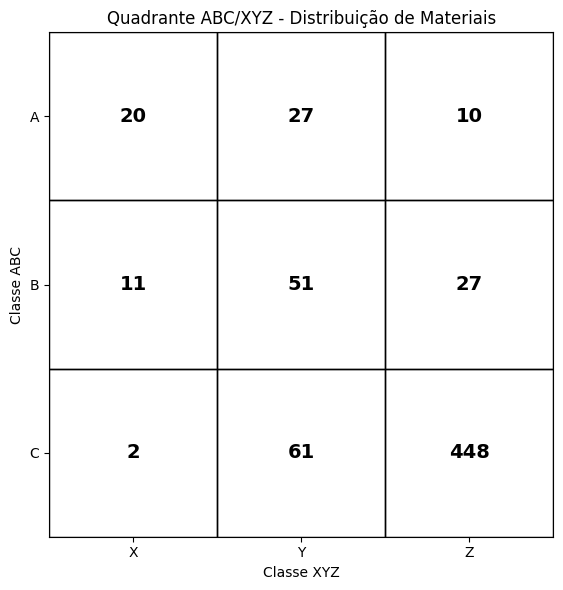

In [302]:
abc_labels = ['A', 'B', 'C']
xyz_labels = ['X', 'Y', 'Z']

tabela = pd.crosstab(df_classificacao['Classe ABC'], df_classificacao['Classe XYZ'])
tabela = tabela.reindex(index=abc_labels, columns=xyz_labels, fill_value=0)
data = tabela.values

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(len(abc_labels)):
    for j in range(len(xyz_labels)):
        valor = data[i, j]
        ax.text(j, i, str(valor), va='center', ha='center', fontsize=14, fontweight='bold', color='black')
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', lw=1))

ax.set_xticks(np.arange(len(xyz_labels)))
ax.set_xticklabels(xyz_labels)
ax.set_yticks(np.arange(len(abc_labels)))
ax.set_yticklabels(abc_labels)
ax.set_xlabel('Classe XYZ')
ax.set_ylabel('Classe ABC')
ax.set_title('Quadrante ABC/XYZ - Distribuição de Materiais')

ax.set_xlim(-0.5, len(xyz_labels) - 0.5)
ax.set_ylim(len(abc_labels) - 0.5, -0.5)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [303]:
pccc_az = df_classificacao[df_classificacao['Classe ABC/XYZ'] == 'AZ'].reset_index()
lista_materiais = pccc_az['Material'].unique().tolist()

In [304]:
lista_materiais

['A33K133',
 'A33K23A',
 'A33K43A',
 'A8DA23K',
 'A8DA33D',
 'AAJW131',
 'AAJW231',
 'AAJW331',
 'AAJW431',
 'PAPEL COUCHE-A3-B']

In [305]:
pccc_total_filtrado_materiais = pccc_total[pccc_total['Material'].isin(lista_materiais)]

In [306]:
pccc_total_filtrado_materiais

,Material,Centro,Depósito,Tipo de movimento,Estoque especial,Doc.material,Item doc.material,Data de lançamento,Qtd. UM registro,UM registro,Cliente,Fornecedor,Nome 1,Canal,Classificação,AnoMes
29,AAJW131,CE11,DEP2,952,NaN,49011275,1,2025-04-01,3,UND,11158.0,NaN,SECRETARIA DE ESTADO DE SAUDE - SES,VENDA DIRETA,VD_CLI_SP,2025-04
193,AAJW131,CE05,DEP2,601,NaN,49011138,5,2025-04-01,4,UND,4653.0,NaN,COPYJUI SOLUCOES DIGITAIS LTDA-EPP,VENDA DIRETA,VD_REV_POA,2025-04
194,AAJW131,CE11,DEP2,952,NaN,49011211,5,2025-04-01,2,UND,2856.0,NaN,DIAGNOSTICOS DA AMERICA S.A.,VENDA DIRETA,VD_CLI_SP,2025-04
195,AAJW131,CE11,DEP2,952,NaN,49011151,2,2025-04-01,7,UND,11453.0,NaN,MAHLE METAL LEVE SA,VENDA DIRETA,VD_CLI_SP,2025-04
196,AAJW131,CE11,DEP2,952,NaN,49011217,5,2025-04-01,2,UND,3735.0,NaN,DIAGNOSTICO DA AMERICA SA,VENDA DIRETA,VD_CLI_SP,2025-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213299,A33K133,CE05,DEP2,601,NaN,49004469,4,2015-03-01,1,UND,3907.0,NaN,AYCA DIGITAL PRINT SOLUTIONS LTDA,VENDA INDIRETA,VI_REVENDA,2015-03
214061,A33K133,CE05,DEP2,601,NaN,49004108,6,2015-03-01,8,UND,4302.0,NaN,DIMEX DO TRIANGULO LTDA,VENDA INDIRETA,VI_REVENDA,2015-03
214623,A33K133,CE05,DEP2,601,NaN,49003965,4,2015-03-01,2,UND,3082.0,NaN,HBL SOL. EM IMP E COPIAS DE DOC.LTD,VENDA INDIRETA,VI_REVENDA,2015-03
214874,A33K133,CE05,DEP2,601,NaN,49003783,1,2015-03-01,5,UND,1591.0,NaN,KONICA MINOLTA B.SOLUTIONS DO SUL L,DESCREDENCIADA,VI_REVENDA,2015-03


In [307]:
pccc_total_filtrado_materiais_1 = pccc_total_filtrado_materiais[pccc_total_filtrado_materiais['AnoMes'] < '2023-12']


In [308]:
previsoes_df = prever_demanda_lstm_por_material_az_sem_plot(
    df=pccc_total_filtrado_materiais_1,
    materiais_az=lista_materiais,
    n_steps=33,
    n_meses_prever=12,
    n_epochs=300
)

previsoes_df

c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Pulando A33K23A - poucos dados (17 meses)
Pulando A33K43A - poucos dados (17 meses)
Pulando A8DA23K - poucos dados (17 meses)
Pulando A8DA33D - poucos dados (16 meses)


c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\fsp_adolpho.salvador\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs

,Material,Mês Previsto,Qtd Prevista
0,A33K133,2023-12,-15.501111
1,A33K133,2024-01,20.160860
2,A33K133,2024-02,18.524963
3,A33K133,2024-03,26.026821
4,A33K133,2024-04,17.835739
...,...,...,...
67,PAPEL COUCHE-A3-B,2023-09,790.680115
68,PAPEL COUCHE-A3-B,2023-10,782.412476
69,PAPEL COUCHE-A3-B,2023-11,773.543762
70,PAPEL COUCHE-A3-B,2023-12,769.114807


In [311]:
previsoes_df.columns

Index(['Material', 'Mês Previsto', 'Qtd Prevista'], dtype='object')

In [312]:
pccc_total_filtrado_materiais.columns

Index(['Material', 'Centro', 'Depósito', 'Tipo de movimento',
       'Estoque especial', 'Doc.material', 'Item doc.material',
       'Data de lançamento', 'Qtd.  UM registro', 'UM registro', 'Cliente',
       'Fornecedor', 'Nome 1', 'Canal', 'Classificação', 'AnoMes'],
      dtype='object')

In [322]:
previsoes_df
valores_unicos = previsoes_df['Material'].unique()


In [323]:
valores_unicos

array(['A33K133', 'AAJW131', 'AAJW231', 'AAJW331', 'AAJW431',
       'PAPEL COUCHE-A3-B'], dtype=object)

In [ ]:

previsoes_2024 = previsoes_df[previsoes_df['Mês Previsto'] >= '2024-01']

dados_reais_2024 = pccc_total_filtrado_materiais[pccc_total_filtrado_materiais['AnoMes'] >= '2024-01']

reais_por_mes = dados_reais_2024.groupby('AnoMes')['Qtd.  UM registro'].sum().reset_index()
reais_por_mes.rename(columns={'AnoMes': 'Mês', 'Qtd.  UM registro': 'Qtd Real'}, inplace=True)

previsoes_por_mes = previsoes_2024.groupby('Mês Previsto')['Qtd Prevista'].sum().reset_index()
previsoes_por_mes.rename(columns={'Mês Previsto': 'Mês'}, inplace=True)

comparacao = pd.merge(previsoes_por_mes, reais_por_mes, on='Mês', how='inner')

comparacao['Erro Absoluto'] = (comparacao['Qtd Prevista'] - comparacao['Qtd Real']).abs()
comparacao['Erro (%)'] = (comparacao['Erro Absoluto'] / comparacao['Qtd Real']) * 100



In [315]:
comparacao

,Mês,Qtd Prevista,Qtd Real,Erro Absoluto,Erro (%)
0,2024-01,2213.193848,1703,510.193848,29.958535
1,2024-02,1530.555176,1605,74.444824,4.638307
2,2024-03,1601.667725,1995,393.332275,19.715904
3,2024-04,1640.110840,5739,4098.889160,71.421662
4,2024-05,1713.528442,2819,1105.471558,39.215025
5,2024-06,1760.042358,2121,360.957642,17.018276
6,2024-07,1804.459229,2131,326.540771,15.323359
7,2024-08,1844.893799,2119,274.106201,12.935640
8,2024-09,1873.292847,1266,607.292847,47.969419
9,2024-10,1912.585205,1412,500.585205,35.452210


In [ ]:
previsoes_A33K133 = previsoes_df[(previsoes_df['Material'] == 'A33K133') & (previsoes_df['Mês Previsto'] >= '2024-01')]

dados_reais_A33K133 = pccc_total_filtrado_materiais[
    (pccc_total_filtrado_materiais['Material'] == 'A33K133') &
    (pccc_total_filtrado_materiais['AnoMes'] >= '2024-01')
]

reais_A33K133_por_mes = dados_reais_A33K133.groupby('AnoMes')['Qtd.  UM registro'].sum().reset_index()
reais_A33K133_por_mes.rename(columns={'AnoMes': 'Mês', 'Qtd.  UM registro': 'Qtd Real'}, inplace=True)

previsoes_A33K133_por_mes = previsoes_A33K133.groupby('Mês Previsto')['Qtd Prevista'].sum().reset_index()
previsoes_A33K133_por_mes.rename(columns={'Mês Previsto': 'Mês'}, inplace=True)

comparacao_A33K133 = pd.merge(previsoes_A33K133_por_mes, reais_A33K133_por_mes, on='Mês', how='inner')

comparacao_A33K133['Erro Absoluto'] = (comparacao_A33K133['Qtd Prevista'] - comparacao_A33K133['Qtd Real']).abs()
comparacao_A33K133['Erro (%)'] = (comparacao_A33K133['Erro Absoluto'] / comparacao_A33K133['Qtd Real']) * 100

media_erro_A33K133 = comparacao_A33K133['Erro (%)'].mean()




In [319]:
comparacao_A33K133

,Mês,Qtd Prevista,Qtd Real,Erro Absoluto,Erro (%)
0,2024-01,20.160860,89,68.839140,77.347348
1,2024-02,18.524963,44,25.475037,57.897811
2,2024-03,26.026821,20,6.026821,30.134106
3,2024-04,17.835739,34,16.164261,47.541944
4,2024-05,56.355442,22,34.355442,156.161100
5,2024-06,69.487297,60,9.487297,15.812162
6,2024-07,78.699417,22,56.699417,257.724623
7,2024-08,82.674988,65,17.674988,27.192289
8,2024-09,78.708336,39,39.708336,101.816246
9,2024-10,86.900795,47,39.900795,84.895308


In [ ]:
previsoes_AAJW131 = previsoes_df[(previsoes_df['Material'] == 'AAJW131') & (previsoes_df['Mês Previsto'] >= '2024-01')]

dados_reais_AAJW131 = pccc_total_filtrado_materiais[
    (pccc_total_filtrado_materiais['Material'] == 'AAJW131') &
    (pccc_total_filtrado_materiais['AnoMes'] >= '2024-01')
]

reais_AAJW131_por_mes = dados_reais_AAJW131.groupby('AnoMes')['Qtd.  UM registro'].sum().reset_index()
reais_AAJW131_por_mes.rename(columns={'AnoMes': 'Mês', 'Qtd.  UM registro': 'Qtd Real'}, inplace=True)

previsoes_AAJW131_por_mes = previsoes_AAJW131.groupby('Mês Previsto')['Qtd Prevista'].sum().reset_index()
previsoes_AAJW131_por_mes.rename(columns={'Mês Previsto': 'Mês'}, inplace=True)

comparacao_AAJW131 = pd.merge(previsoes_AAJW131_por_mes, reais_AAJW131_por_mes, on='Mês', how='inner')

comparacao_AAJW131['Erro Absoluto'] = (comparacao_AAJW131['Qtd Prevista'] - comparacao_AAJW131['Qtd Real']).abs()
comparacao_AAJW131['Erro (%)'] = (comparacao_AAJW131['Erro Absoluto'] / comparacao_AAJW131['Qtd Real']) * 100

media_erro_AAJW131 = comparacao_AAJW131['Erro (%)'].mean()


In [ ]:
comparacao_AAJW131


,Mês,Qtd Prevista,Qtd Real,Erro Absoluto,Erro (%)
0,2024-01,649.813477,243,406.813477,167.412953
1,2024-02,665.633667,458,207.633667,45.334862
2,2024-03,698.212646,718,19.787354,2.755899
3,2024-04,738.086731,1315,576.913269,43.871731
4,2024-05,767.393616,986,218.606384,22.171033
5,2024-06,786.821838,402,384.821838,95.726825
6,2024-07,802.092041,619,183.092041,29.578682
7,2024-08,814.631470,614,200.631470,32.676135
8,2024-09,825.036499,464,361.036499,77.809590
9,2024-10,833.393066,552,281.393066,50.977005


In [ ]:
media_erro_AAJW131

54.05805384247251

# explicaçao


##  **Modelo Utilizado: LSTM**

O modelo aplicado para a previsão de demanda foi a LSTM especializada em aprender padrões de séries temporais, como sazonalidade, tendência e flutuações históricas.

A LSTM é especialmente eficaz em séries temporais **com dependências de longo prazo**, pois mantém "memória" de padrões anteriores, ajustando sua previsão com base em janelas de tempo passadas (definidas por `n_steps`). Neste caso:

- Foram utilizados **`n_steps = 194`** , ou seja, o modelo aprendeu com **194 meses anteriores**
- Treinamento foi feito com **`epochs = 400`**, permitindo que o modelo ajustasse bem seus pesos

---

##  **Resultados e Análise das Previsões**

### 🔹 **Previsão Total (Todos os Canais)**
| MAPE: **13.85%** |
- Boa performance geral, com vários meses abaixo de 10% de erro
- Erros mais altos nos extremos (jan, fev, dez) indicam **sazonalidade forte não capturada**
- Dezembro tem erro alto (34%), comum em meses com picos de demanda não recorrentes

---

### 🔹 **VENDA DIRETA**
| MAPE: **10.36%** |
- Excelente desempenho: a maioria dos meses apresenta erros **abaixo de 10%**
- Apenas jan, fev e maio passaram de 20%, indicando variações atípicas ou rupturas no padrão
- Modelo claramente **aprendeu bem o comportamento do canal VENDA DIRETA**

---

### 🔹 **VENDA INDIRETA**
| MAPE: **17.64%** |
- Desempenho razoável, mas com **alguns meses críticos**:
  - Novembro: erro de 41%
  - Dezembro: erro de 44%
- O modelo teve dificuldade de capturar os picos (possivelmente ligados a promoções ou sazonalidades fortes)
- Apesar disso, vários meses (mar, jul, set) tiveram erro **abaixo de 10%**

---

##  Conclusão

- O uso de LSTM se mostrou **eficaz** na modelagem da demanda total e por canal.
- **VENDA DIRETA teve a menor margem de erro** e uma curva muito mais estável, indicando previsibilidade maior nesse segmento.
- **VENDA INDIRETA exige ajustes no modelo ou inclusão de variáveis externas**, como promoções ou sazonalidade explícita, para capturar os picos.
- A previsão agregada (todos os canais) apresentou **bom equilíbrio**, mesmo com outliers como dezembro.

